# Lights 

> Defines some light schedules for building circadian models

In [ ]:
#| default_exp lights

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
from fastcore.basics import *

In [ ]:
#| export 

from matplotlib.pyplot import step
import numpy as np
from numpy.core.fromnumeric import repeat
import pylab as plt
from typing import Optional

In [ ]:
#| export

class Light:

    def __init__(self, 
                 light: callable, # light function that takes in a time value and returns a float, if a float is passed, then the light function is a constant set to that lux value 
                 start_time: float = 0.0, # when the light function starts in hours
                 duration: float = 1.0, # duration of the light function in hours
                 default_value=0.0 # the default value of the light function when it is not active
                 ):
        if type(light) is float:
            self._func = np.vectorize(lambda t: light, otypes=[float])
        else:
            self._func = np.vectorize(light, otypes=[float])
        self.default_value = default_value
        self.start_time = start_time
        self.duration = duration

    @property
    def end_time(self):
        return self.start_time + self.duration

    def __call__(self, 
                 t: np.ndarray, # time values in hours to evaluate the light function
                 repeat_period: float = None # should the light function repeat after a certain period
                 ):
        t = np.array(t)
        if repeat_period is not None:
            t = np.mod(t, repeat_period)
        default_result = np.zeros_like(t) + self.default_value
        mask = (t >= self.start_time) & (t <= self.end_time)
        func_result  = self._func(t[mask])
        default_result[mask] += func_result
        return default_result

    def __add__(self, light_obj: 'Light'):
        switch_time = self.end_time
        def light_func_new(t): return np.piecewise(t, [t <= switch_time, t >= switch_time],                                       [
            self._func, lambda t: light_obj._func(t-switch_time)])

        start_time_new = min(self.start_time, light_obj.start_time)
        duration_new = light_obj.duration + self.duration
        return Light(light_func_new, start_time=start_time_new, duration=duration_new)

    def plot(self,
             start_time: float = None, 
             end_time: float = None,
             ax=None, 
             show_plot=True, 
             num_samples=10000,
             *args,
             **kwargs):
        
        if start_time is None:
            start_time = self.start_time
        if end_time is None:
            end_time = self.end_time
            
        t = np.linspace(start_time, end_time, num_samples)
        vals = self.__call__(t)
        if ax is None:
            plt.figure()
            ax = plt.gca()

        ax.plot(t, vals, *args, **kwargs)
        if show_plot:
            plt.show()
        return ax
    
    @staticmethod
    def RegularLight(lux=150.0, # lux intensity of the light
                 lights_on=8.0, # hour of the day for lights to come on
                 lights_off=16.0, # hour of the day for lights to go off
                 ) -> 'Light':

        lights_on = np.mod(lights_on, 24.0)
        lights_off = np.mod(lights_off, 24.0)
        if lights_off > lights_on:
            end_time = lights_on + (lights_off - lights_on) 
            dark_section_before = Light(0.0, start_time=0.0, duration=lights_on)
            light_section = Light(lux, 
                         start_time=lights_on, 
                         duration=lights_off - lights_on)
            dark_section = Light(0.0, end_time, duration=24.0 - end_time)
            return dark_section_before + light_section + dark_section 
        else:
            first_light = Light(lux, start_time = 0.0, duration=lights_off)
            dark_section = Light(0.0, start_time=lights_off, duration=lights_on - lights_off)
            second_light = Light(lux, start_time=lights_on, duration=24.0 - lights_on)
            return  first_light + dark_section + second_light
        
    @staticmethod
    def ShiftWorkLight(lux: float = 150.0, # lux intensity of the light
                   dayson: int = 3, # number of days on the night shift
                   daysoff: int = 2 # number of days off shift
                   ) -> 'Light':
        
        workday = Light.RegularLight(lux=lux, lights_on=19.0, lights_off=11.0)
        offday = Light.RegularLight(lux=lux, lights_on=7.0, lights_off=23.0)
        total_schedule = [workday for _ in range(dayson-1)] + [offday for _ in range(daysoff)]
        for day in total_schedule:
            workday += day
        return workday
    
    @staticmethod
    def SlamShift(lux: float = 150.0, # lux intensity of the light
                  shift=8.0, # number of hours to shift the light schedule
                  before_days=10, #number of days before the shift occurs 
                  starting_lights_on=8.0, # hour of the day for lights to come on
                  after_days=10 # number of days after the shift occurs
                  ) -> 'Light':
        
        light_before = Light.RegularLight(lux=lux, 
                                          lights_on=starting_lights_on, 
                                          lights_off= np.fmod(starting_lights_on + 16.0, 24.0)
                                          )
        light_after = Light.RegularLight(lux=lux, 
                                         lights_on=np.fmod(starting_lights_on+shift, 24.0), 
                                         lights_off=np.fmod(starting_lights_on+shift+16.0, 24.0)
                                         )
        total_schedule = [light_before for _ in range(before_days-1)] + [light_after for _ in range(after_days)]
        for day in total_schedule:
            light_before += day
        return light_before
    
    @staticmethod
    def SocialJetlag(lux: float = 150.0, # lux intensity of the light
                num_regular_days: int = 5, # number of days with a regular schedule
                num_jetlag_days: int = 2, # number of days with a delayed schedule
                hours_delayed: float = 2.0, # number of hours to delay the schedule on the jetlag days
                regular_days_lights_on=7.0, # hour of the day for lights to come on
                ) -> 'Light':
    
        jetlag_day_lights_on = (regular_days_lights_on + hours_delayed) 
        jetlag_day_lights_off = (regular_days_lights_on+ 16.0 + hours_delayed) 
        regular_days = Light.RegularLight(lux=lux, lights_on=regular_days_lights_on, lights_off=regular_days_lights_on+16.0)
        jetlag_day = Light.RegularLight(lux=lux, lights_on=jetlag_day_lights_on, lights_off=jetlag_day_lights_on + 16.0)
        total_schedule = [regular_days for _ in range(num_regular_days-1)] + [jetlag_day for _ in range(num_jetlag_days)]
        for day in total_schedule:
            regular_days += day
        return regular_days
        



In [ ]:
lf_init = Light(lambda t: 1.0, start_time=0.0, duration=1.0) 
lf_init_from_float = Light(1.0, start_time=0.0, duration=1.0) # creates a consant light function from the float value

test_eq(lf_init([0.5]), 1.0)
test_eq(lf_init_from_float([0.5]), 1.0)

## Some Common Schedules


In [ ]:
#| export

def make_pulse(t, tstart, tend, steep: float = 30.0):
    return 0.5*np.tanh(steep*(t-tstart))-0.5*np.tanh(steep*(t-tend))

def get_pulse(t: float,
              t1: float,
              t2: float,
              repeat=False,
              Intensity: float = 150.0):

    if repeat:
        t = np.fmod(t, 24.0)
    if t < 0.0:
        t += 24.0

    light_value = Intensity*make_pulse(t, t1, t2)
    return np.abs(light_value)


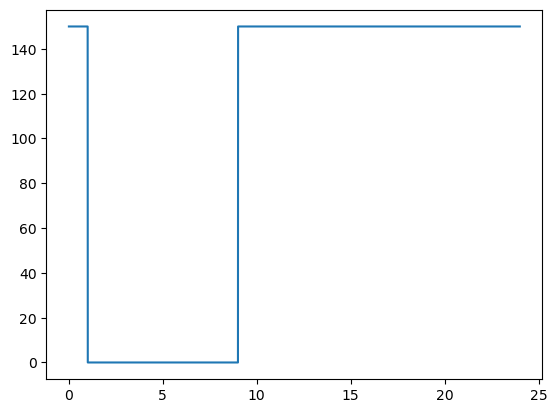

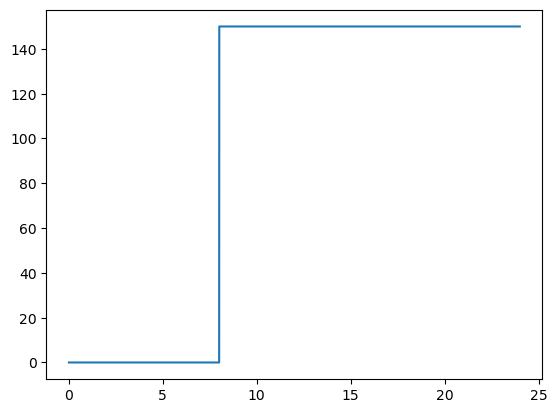

In [ ]:
LR_test = Light.RegularLight(lights_on=9.0, lights_off=1.0)
LR_test.plot(0.0, 24.0);

LR_test = Light.RegularLight(lights_on=8.0, lights_off=0.0)
LR_test.plot(0.0, 24.0);


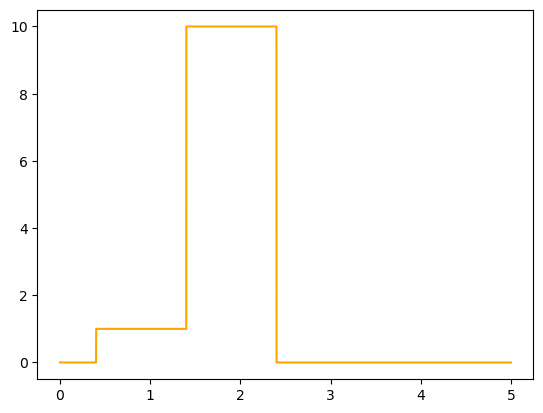

In [ ]:
light_sum = Light(1.0, start_time=0.4, duration=1.0) + Light(10.0, start_time=3.0, duration=1.0)
light_sum.plot(0.0, 5.0, color='orange');


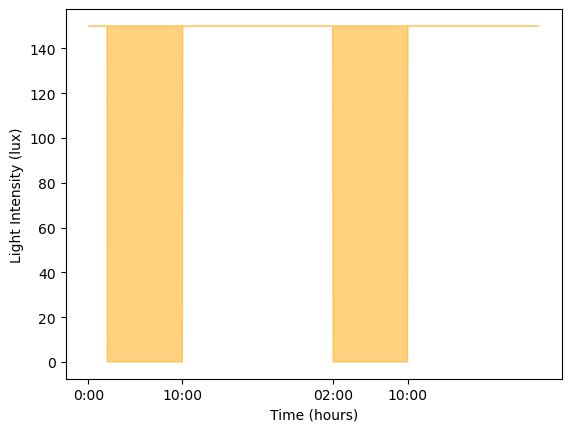

In [ ]:
LR = Light.RegularLight(lux=150.0, lights_on=10.0, lights_off=2.0)

timepoints = np.linspace(0, 48, 1000)
light_values = LR(timepoints, repeat_period=24.0)

plt.fill(timepoints, light_values, color='orange', alpha=0.5);
plt.xticks([0, 10, 26, 34], ['0:00','10:00', '02:00', '10:00']);
plt.ylabel('Light Intensity (lux)');
plt.xlabel('Time (hours)');

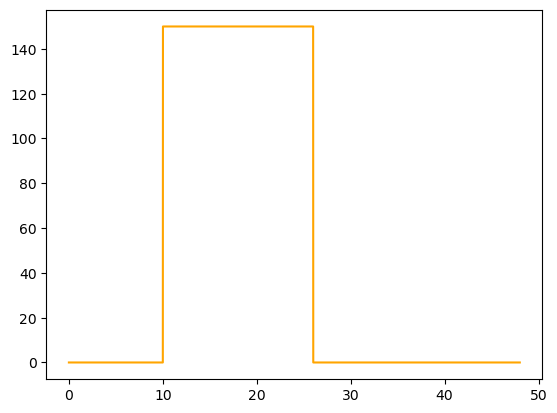

In [ ]:
lf = Light(lambda t: 150.0, start_time=10.0, duration=16.0)
lf.plot(start_time=0.0, end_time=48.0, color='orange');


In [ ]:
test_eq(lf(np.array([10.0])), 150.0)
test_eq(lf(np.array([2.0])), 0.0)
test_eq(lf(np.array([34.0]), repeat_period=24.0), 150.0) # should repeat every 24 hours

In [ ]:
# can pass in a list and get an numpy array back
test_eq(type(lf([2.0])), np.ndarray)


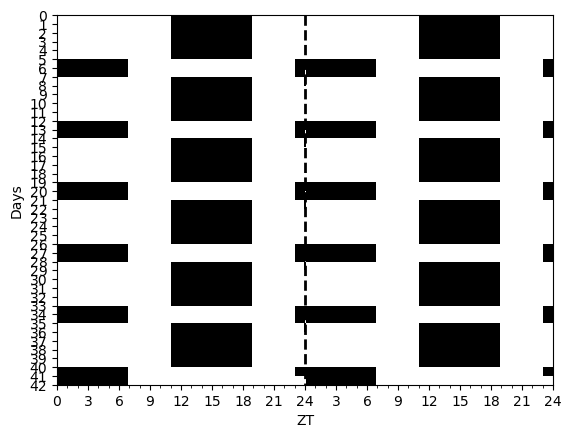

In [ ]:
from circadian.plots import Actogram 

sw_light = Light.ShiftWorkLight(dayson=5, daysoff=2)
ts = np.arange(0, 24*7*6, 0.10)
light_values = sw_light(ts, repeat_period=24*7)

Actogram(ts, light_vals=light_values, smooth=False);



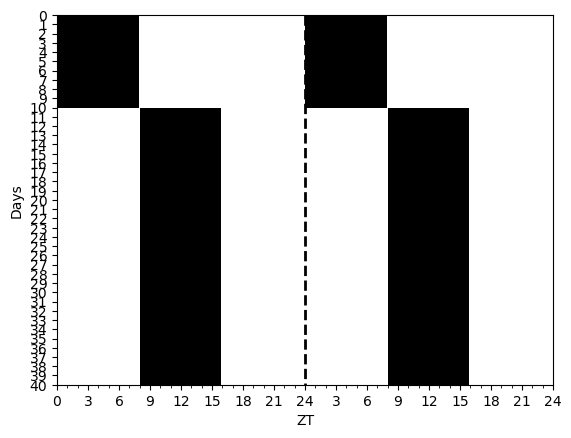

In [ ]:


slam_shift = Light.SlamShift(shift=8.0,
                             before_days=10, 
                             after_days=40)
ts = np.arange(0, 24*40, 0.10)
light_values = slam_shift(ts)

Actogram(ts, light_vals=light_values, smooth=False);

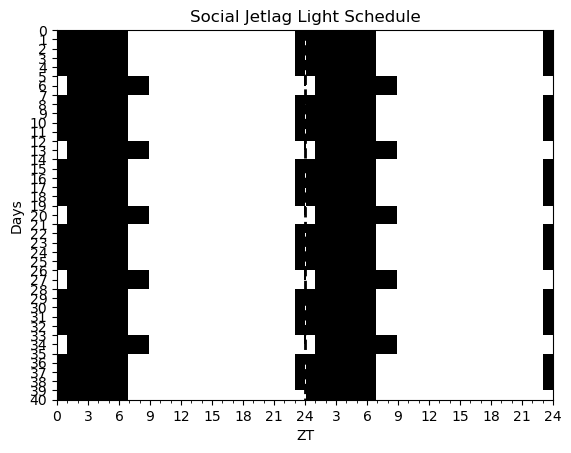

In [ ]:
social_jl = Light.SocialJetlag()
ts = np.arange(0, 24*40, 0.10)
light_values = social_jl(ts, repeat_period=24*7)

Actogram(ts, light_vals=light_values, smooth=False);
plt.title("Social Jetlag Light Schedule");

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()